# Trabajo Práctico Final

In [174]:
import numpy as np
from numpy.linalg import det, inv
from sklearn.datasets import load_iris, fetch_openml
from sklearn.model_selection import train_test_split

In [175]:
class ClassEncoder:
    def fit(self, y):
        self.names = np.unique(y)
        self.name_to_class = {name:idx for idx, name in enumerate(self.names)}
        self.fmt = y.dtype

    def _map_reshape(self, f, arr):
        return np.array([f(elem) for elem in arr.flatten()]).reshape(arr.shape)

    def transform(self, y):
        return self._map_reshape(lambda name: self.name_to_class[name], y)

    def fit_transform(self, y):
        self.fit(y)
        return self.transform(y)

    def detransform(self, y_hat):
        return self._map_reshape(lambda idx: self.names[idx], y_hat)

In [176]:
class BaseBayesianClassifier:
    def __init__(self):
        self.encoder = ClassEncoder()

    def _estimate_a_priori(self, y):
        a_priori = np.bincount(y.flatten().astype(int)) / y.size
        return np.log(a_priori)

    def _fit_params(self, X, y):
        raise NotImplementedError()

    def _predict_log_conditional(self, x, class_idx):
        raise NotImplementedError()

    def fit(self, X, y, a_priori=None):
        y = self.encoder.fit_transform(y)
        self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)
        assert len(self.log_a_priori) == len(self.encoder.names), "A priori probabilities do not match number of classes"
        self._fit_params(X, y)

    def predict(self, X):
        m_obs = X.shape[1]
        y_hat = np.empty(m_obs, dtype=self.encoder.fmt)
        for i in range(m_obs):
            encoded_y_hat_i = self._predict_one(X[:,i].reshape(-1,1))
            y_hat[i] = self.encoder.names[encoded_y_hat_i]
        return y_hat.reshape(1,-1)

    def _predict_one(self, x):
        log_posteriori = [log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                          in enumerate(self.log_a_priori)]
        return np.argmax(log_posteriori)

In [177]:
class QDA(BaseBayesianClassifier):
    def _fit_params(self, X, y):
        self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))
                         for idx in range(len(self.log_a_priori))]
        self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                      for idx in range(len(self.log_a_priori))]

    def _predict_log_conditional(self, x, class_idx):
        inv_cov = self.inv_covs[class_idx]
        unbiased_x =  x - self.means[class_idx]
        return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

In [178]:
class TensorizedQDA(QDA):
    def _fit_params(self, X, y):
        super()._fit_params(X,y)
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x
        return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

## Funciones auxiliares

In [179]:
def get_iris_dataset():
    data = load_iris()
    X_full = data.data
    y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
    return X_full, y_full

def get_penguins():
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')
    df.drop(columns=["island","sex"], inplace=True)
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]
    return df.values, tgt.to_numpy().reshape(-1,1)

def split_transpose(X, y, test_sz, random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_sz, random_state=random_state)
    return X_train.T, y_train.T, X_test.T, y_test.T

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

## Ejemplo de entrenamiento

In [180]:
# hiperparámetros
rng_seed = 6543

# Cargar y preparar los datos
X_full, y_full = get_iris_dataset()
print(f"X: {X_full.shape}, Y:{y_full.shape}")

# Dividir los datos en conjuntos de entrenamiento y prueba
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

# Entrenar un modelo QDA
qda = QDA()
qda.fit(train_x, train_y)

# Evaluar el modelo
train_acc = accuracy(train_y, qda.predict(train_x))
test_acc = accuracy(test_y, qda.predict(test_x))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

X: (150, 4), Y:(150, 1)
(4, 90) (1, 90) (4, 60) (1, 60)
Train (apparent) error is 0.0111 while test error is 0.0167


## Ejemplos de medición de tiempos

In [181]:
%%timeit

qda.predict(test_x)

1.02 ms ± 25.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [182]:
%%timeit

model = QDA()
model.fit(train_x, train_y)
model.predict(test_x)

1.12 ms ± 5.93 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Implementación base
1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.
    1. Uniforme (cada clase tiene probabilidad 1/3)
    2. Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)
2. Repetir el punto anterior para el dataset *penguin*.
3. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA (no múltiples prioris) ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?
4. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?
5. Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?


**Sugerencia:** puede resultar de utilidad para cada inciso de comparación utilizar tablas del siguiente estilo:

<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Iris | 125 | 0.55 | 0.85
LDA | Iris | 125 | 0.22 | 0.8

</center>


### 1. Entrenar QDA sobre el dataset iris con diferentes distribuciones a priori

In [183]:
# Se instancia QDA
qda = QDA()

# Se genera un array con las probabilidades de las distintas clases para el dataset iris
probability_arrays = np.array([np.full(3,1/3),np.full(3,[.05,.05,.9]),np.full(3,[.05,.9,.05]),np.full(3,[.9,.05,.05])])
for prob_array in probability_arrays:

    qda.fit(train_x, train_y, prob_array)
    train_acc = accuracy(train_y, qda.predict(train_x))
    test_acc = accuracy(test_y, qda.predict(test_x))
    print(f"Train error for iris dataset and apriori probability distribution {prob_array} is {1 - train_acc:.4f}")
    print(f"Test error for the same dataset:  {1 - test_acc:.4f}")


Train error for iris dataset and apriori probability distribution [0.33333333 0.33333333 0.33333333] is 0.0222
Test error for the same dataset:  0.0167
Train error for iris dataset and apriori probability distribution [0.05 0.05 0.9 ] is 0.0333
Test error for the same dataset:  0.0500
Train error for iris dataset and apriori probability distribution [0.05 0.9  0.05] is 0.0333
Test error for the same dataset:  0.0000
Train error for iris dataset and apriori probability distribution [0.9  0.05 0.05] is 0.0222
Test error for the same dataset:  0.0167


### 2. Repetir el punto anterior para el dataset penguin

In [184]:
# Código para el punto 2

# Cargar y preparar los datos
X_penguins_full, y_penguins_full = get_penguins()
print(f"X: {X_penguins_full.shape}, Y:{y_penguins_full.shape}")

# Dividir los datos en conjuntos de entrenamiento y prueba
train_x_penguins, train_y_penguins, test_x_penguins, test_y_penguins = split_transpose(X_penguins_full, y_penguins_full, 0.4, rng_seed)
print(train_x_penguins.shape, train_y_penguins.shape, test_x_penguins.shape, test_y_penguins.shape)

# Entrenar un modelo QDA
qda_penguins = QDA()
for prob_array in probability_arrays:

    qda_penguins.fit(train_x_penguins, train_y_penguins,prob_array)
    penguins_train_acc = accuracy(train_y_penguins, qda_penguins.predict(train_x_penguins))
    penguins_test_acc = accuracy(test_y_penguins, qda_penguins.predict(test_x_penguins))
    print(f"Train error for penguin dataset and apriori probability distribution {prob_array} is {1 - penguins_train_acc:.4f}")
    print(f"Test error for the same dataset:  {1 - penguins_test_acc:.4f}")


X: (342, 4), Y:(342, 1)
(4, 205) (1, 205) (4, 137) (1, 137)
Train error for penguin dataset and apriori probability distribution [0.33333333 0.33333333 0.33333333] is 0.0098
Test error for the same dataset:  0.0073
Train error for penguin dataset and apriori probability distribution [0.05 0.05 0.9 ] is 0.0098
Test error for the same dataset:  0.0073
Train error for penguin dataset and apriori probability distribution [0.05 0.9  0.05] is 0.0098
Test error for the same dataset:  0.0219
Train error for penguin dataset and apriori probability distribution [0.9  0.05 0.05] is 0.0195
Test error for the same dataset:  0.0219


### 3. Implementar LDA y comparar con QDA

In [185]:
# Código para el punto 3
class LDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    cov_matrices = [np.cov(X[:,y.flatten()==idx], bias=True) for idx in range(len(self.log_a_priori))]
    class_frequencies = np.bincount(y.flatten().astype(int)) / y.size

    weighted_cov_mean = sum(cov_matrix * weight for cov_matrix, weight in zip(cov_matrices, class_frequencies))
    self.inv_cov = inv(weighted_cov_mean)

    self.means = np.array([X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))])

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_cov
    half_unbiased_x =  x - 0.5*self.means[class_idx]
    return self.means[class_idx].T @ inv_cov @ half_unbiased_x
  
#Prueba con Iris
lda_iris = LDA()

prob_array_iris = np.full(3,1/3)

lda_iris.fit(train_x, train_y, prob_array)
train_acc = accuracy(train_y, lda_iris.predict(train_x))
test_acc = accuracy(test_y, lda_iris.predict(test_x))
print(f"Testing LDA for iris dataset and apriori probability distribution")
print(f"Train error for iris dataset and apriori probability distribution {prob_array_iris} is {1 - train_acc:.4f}")
print(f"Test error for the same dataset:  {1 - test_acc:.4f}")

#Prueba con dataset penguin
lda_penguin = LDA()

prob_array_penguin = np.full(3,1/3)

lda_penguin.fit(train_x_penguins, train_y_penguins, prob_array)
penguins_train_acc = accuracy(train_y_penguins, lda_penguin.predict(train_x_penguins))
penguins_test_acc = accuracy(test_y_penguins, lda_penguin.predict(test_x_penguins))
print(f"Testing LDA for Penguin dataset")
print(f"Train error for Penguin dataset and apriori probability distribution {prob_array_penguin} is {1 - penguins_train_acc:.4f}")
print(f"Test error for the same dataset:  {1 - penguins_test_acc:.4f}")



Testing LDA for iris dataset and apriori probability distribution
Train error for iris dataset and apriori probability distribution [0.33333333 0.33333333 0.33333333] is 0.0222
Test error for the same dataset:  0.0167
Testing LDA for Penguin dataset
Train error for Penguin dataset and apriori probability distribution [0.33333333 0.33333333 0.33333333] is 0.0195
Test error for the same dataset:  0.0219


### 4. Repetir la comparación con diferentes random seeds

In [186]:

seeds = [456, 1789]
lda = LDA()
qda = QDA()
prob_array=np.full(3,1/3)

for seed in seeds:
    train_x_iris, train_y_iris, test_x_iris, test_y_iris = split_transpose(X_full, y_full, 0.4, seed)
    train_x_penguins, train_y_penguins, test_x_penguins, test_y_penguins = split_transpose(X_penguins_full, y_penguins_full, 0.4, seed)

    #Se efectua prueba con dataset penguin (LDA y QDA)

    lda.fit(train_x_penguins, train_y_penguins, prob_array)
    train_acc = accuracy(train_y_penguins, lda.predict(train_x_penguins))
    test_acc = accuracy(test_y_penguins, lda.predict(test_x_penguins))
    print(f"[LDA]Train (apparent) error for penguins dataset for apriori distribution {prob_array} is {1 - train_acc:.4f} while test error is {1 - test_acc:.4f}.Rng seed is {seed}")

    qda.fit(train_x_penguins, train_y_penguins, prob_array)
    train_acc = accuracy(train_y_penguins, qda.predict(train_x_penguins))
    test_acc = accuracy(test_y_penguins, qda.predict(test_x_penguins))
    print(f"[QDA]Train (apparent) error for penguins dataset for apriori distribution {prob_array} is {1 - train_acc:.4f} while test error is {1 - test_acc:.4f}.Rng seed is {seed}")

    #Se efectua prueba con dataset iris
    lda.fit(train_x_iris, train_y_iris, prob_array)
    train_acc = accuracy(train_y_iris, lda.predict(train_x_iris))
    test_acc = accuracy(test_y_iris, lda.predict(test_x_iris))
    print(f"[LDA]Train (apparent) error for iris dataset for apriori distribution {prob_array} is {1 - train_acc:.4f} while test error is {1 - test_acc:.4f}. Rng seed is {seed}")
    
    qda.fit(train_x_iris, train_y_iris, prob_array)
    train_acc = accuracy(train_y_iris, qda.predict(train_x_iris))
    test_acc = accuracy(test_y_iris, qda.predict(test_x_iris))
    print(f"[QDA]Train (apparent) error for iris dataset for apriori distribution {prob_array} is {1 - train_acc:.4f} while test error is {1 - test_acc:.4f}. Rng seed is {seed}")




[LDA]Train (apparent) error for penguins dataset for apriori distribution [0.33333333 0.33333333 0.33333333] is 0.0098 while test error is 0.0073.Rng seed is 456
[QDA]Train (apparent) error for penguins dataset for apriori distribution [0.33333333 0.33333333 0.33333333] is 0.0098 while test error is 0.0146.Rng seed is 456
[LDA]Train (apparent) error for iris dataset for apriori distribution [0.33333333 0.33333333 0.33333333] is 0.0222 while test error is 0.0167. Rng seed is 456
[QDA]Train (apparent) error for iris dataset for apriori distribution [0.33333333 0.33333333 0.33333333] is 0.0222 while test error is 0.0167. Rng seed is 456
[LDA]Train (apparent) error for penguins dataset for apriori distribution [0.33333333 0.33333333 0.33333333] is 0.0049 while test error is 0.0146.Rng seed is 1789
[QDA]Train (apparent) error for penguins dataset for apriori distribution [0.33333333 0.33333333 0.33333333] is 0.0049 while test error is 0.0146.Rng seed is 1789
[LDA]Train (apparent) error for 

### 5. Comparar tiempos de predicción entre QDA y TensorizedQDA

In [187]:
qda = QDA()
qda.fit(train_x, train_y)

qda_tensorized = TensorizedQDA()
qda_tensorized.fit(train_x, train_y)

In [35]:
%%timeit

qda.predict(test_x)

11.5 ms ± 599 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
%%timeit

qda_tensorized.predict(test_x)

4.55 ms ± 354 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Optimización matemática

**Sugerencia:** considerar combinaciones adecuadas de `transpose`, `reshape` y, ocasionalmente, `flatten`. Explorar la dimensionalidad de cada elemento antes de implementar las clases.

### QDA

Debido a la forma cuadrática de QDA, no se puede predecir para *n* observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de *n x n* en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

1. Implementar el modelo `FasterQDA` (se recomienda heredarlo de TensorizedQDA) de manera de eliminar el ciclo for en el método predict.
2. Comparar los tiempos de predicción de `FasterQDA` con `TensorizedQDA` y `QDA`.
3. Mostrar (puede ser con un print) dónde aparece la mencionada matriz de *n x n*, donde *n* es la cantidad de observaciones a predecir.
4. Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.
5.Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente. ¿Hay cambios en los tiempos de predicción?


### LDA

1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado. *Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*
2. LDA no sufre del problema antes descrito de QDA debido a que no computa productos internos, por lo que no tiene un verdadero costo extra en memoria predecir "en batch". Implementar el modelo `FasterLDA` y comparar sus tiempos de predicción con las versiones anteriores de LDA.

#### Setup

In [188]:
import timeit

X_full, y_full = get_iris_dataset()
print(f"X: {X_full.shape}, Y:{y_full.shape}")
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

def compare_models(X_train, y_train, X_test, models, number=100):
    results = []

    # Ajustar y evaluar cada modelo
    for model in models:
        model_name = model.__class__.__name__
        try:
            # Ajustar el modelo
            model.fit(X_train, y_train)

            # Medir el tiempo de ejecución
            predict_func = lambda: model.predict(X_test)
            execution_time = timeit.timeit(predict_func, number=number) / number


            results.append({
                'Modelu': model_name,
                'Tiempo promedio de ejecución: (s)': execution_time
            })

            print(f"Modelo: {model_name}")
            print(f"Tiempo promedio de ejecución: {execution_time:.6f} segundos")
            print("-" * 50)

        except Exception as e:
            print(f"Error con {model_name}: {e}")
            print("-" * 50)

    return results

X: (150, 4), Y:(150, 1)


### QDA

#### 1. Implementación de FasterQDA:

In [189]:
class FasterQDA(TensorizedQDA):
    def __init__(self):
        super().__init__()
        self.show_n_by_n_matrix = False

    def _predict_log_conditionals(self, x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0, 2, 1) @ self.tensor_inv_cov @ unbiased_x

        if self.show_n_by_n_matrix:
            self._show_n_by_n_matrix(inner_prod)


        diag_inner_prod = np.stack([np.diagonal(inner_prod[i]) for i in range(inner_prod.shape[0])])
        return 0.5 * np.log(det(self.tensor_inv_cov)).reshape(3, 1) - 0.5 * diag_inner_prod
    
    def _show_n_by_n_matrix(self, matrix):
        print(f"Matriz n x n (donde n es el número de observaciones a predecir):")
        print(f"Forma de la matriz: {matrix.shape}")
        print("Primeras filas y columnas de la matriz:")
        print(matrix[0, :5, :5])  # Mostrar solo una parte de la matriz

    def predict(self, X):
        m_obs = X.shape[1]
        y_hat = np.empty(m_obs, dtype=self.encoder.fmt)
        stacked_X = np.stack(X)

        encoded_y_hat_i = np.argmax(self.log_a_priori.reshape(3, 1) + self._predict_log_conditionals(stacked_X), axis=0)

        y_hat = self.encoder.names[encoded_y_hat_i]

        return y_hat

#### 2. Comparación de tiempos de predicción:

In [190]:
import pandas as pd

models = [
    QDA(),
    TensorizedQDA(),
    FasterQDA()
]

results = compare_models(train_x, train_y, test_x, models)

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

Modelo: QDA
Tiempo promedio de ejecución: 0.001400 segundos
--------------------------------------------------
Modelo: TensorizedQDA
Tiempo promedio de ejecución: 0.000582 segundos
--------------------------------------------------
Modelo: FasterQDA
Tiempo promedio de ejecución: 0.000032 segundos
--------------------------------------------------
       Modelu  Tiempo promedio de ejecución: (s)
          QDA                           0.001400
TensorizedQDA                           0.000582
    FasterQDA                           0.000032


#### 3. Matriz n x n en FasterQDA:

La matriz n x n aparece en el método `_predict_log_conditionals`:
```python
inner_prod = unbiased_x.transpose(0, 2, 1) @ self.tensor_inv_cov @ unbiased_x
```

Esta operación produce una matriz de forma (3, 60, 60), donde 60 es el número de observaciones a predecir.


In [191]:
fqda = FasterQDA()
fqda.fit(train_x, train_y)

fqda.show_n_by_n_matrix = True

fqda.predict(test_x)

Matriz n x n (donde n es el número de observaciones a predecir):
Forma de la matriz: (3, 60, 60)
Primeras filas y columnas de la matriz:
[[349.14286233 468.41721969 526.1539483   29.58564752 549.38070701]
 [468.41721969 634.30306746 709.04963714  42.20919219 740.77536697]
 [526.1539483  709.04963714 796.27377657  44.99957285 828.81320264]
 [ 29.58564752  42.20919219  44.99957285   6.52479153  50.03072051]
 [549.38070701 740.77536697 828.81320264  50.03072051 868.19357783]]


array(['versicolor', 'versicolor', 'virginica', 'setosa', 'virginica',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'virginica', 'versicolor', 'versicolor', 'virginica', 'setosa',
       'setosa', 'versicolor', 'setosa', 'setosa', 'versicolor', 'setosa',
       'versicolor', 'setosa', 'virginica', 'setosa', 'virginica',
       'setosa', 'versicolor', 'setosa', 'versicolor', 'virginica',
       'versicolor', 'setosa', 'versicolor', 'virginica', 'virginica',
       'versicolor', 'virginica', 'versicolor', 'setosa', 'virginica',
       'setosa', 'virginica', 'setosa', 'setosa', 'versicolor',
       'virginica', 'virginica', 'setosa', 'setosa', 'setosa',
       'virginica', 'virginica', 'versicolor', 'setosa', 'virginica',
       'setosa', 'versicolor', 'setosa', 'setosa', 'setosa'], dtype='<U10')

#### 4. Demostración de la propiedad matricial

Vamos a demostrar que:

$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$

es decir, que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.

#### Paso 1: Expresión del producto matricial

Si expresamos el producto matricial $A \cdot B$ como una suma de multiplicaciones de fila por columna, podemos expresar elemento a elemento la matriz resultado de la siguiente manera:

$$(A \cdot B)_{ij} = \sum_{k} A_{ik} B_{kj}$$

#### Paso 2: Elementos de la diagonal

Los elementos de la diagonal de la matriz resultado del producto pueden ser escritos de esta manera como:

$$\text{diag}(A \cdot B) = \left( \sum_{k} A_{1k} B_{k1} , \sum_{k} A_{2k} B_{k2} ,  \ldots  , \sum_{k} A_{nk} B_{kn} \right)$$

#### Paso 3: Producto elemento a elemento

Ahora expresando el producto elemento a elemento de A y B transpuesta como:

$$(A \odot B^T)_{ij} = A_{ij} \cdot B_{ji}$$

#### Paso 4: Suma sobre las columnas

El último paso es ver que sumando sobre todas las columnas (índice j) obtenemos cada elemento de la diagonal expresada antes, es decir:

$$\text{diag}(A \cdot B) = \sum_{\text{cols}} A \odot B^T$$

Esta demostración prueba que podemos obtener la diagonal del producto de dos matrices $A \cdot B$ sin necesidad de calcular explícitamente la matriz completa, lo cual es especialmente útil cuando trabajamos con matrices grandes, ya que nos permite "esquivar" la creación de una matriz *n x n* intermedia.

In [192]:
def demonstrate_matrix_property(n=5, p=3):
    # Crear matrices aleatorias A y B
    A = np.random.rand(n, p)
    B = np.random.rand(p, n)
    
    print("Demostración de la propiedad matricial:")
    print(f"diag(A · B) = Σ_cols A ⊙ B^T = np.sum(A ⊙ B^T, axis=1)")
    
    # Calcular diag(A · B)
    diag_AB = np.diag(A @ B)
    
    # Calcular Σ_cols A ⊙ B^T
    sum_product_product = np.sum(A * B.T, axis=1)
    
    print("\nForma de A:", A.shape)
    print("Forma de B:", B.shape)
    print("\nResultado de diag(A · B):")
    print(diag_AB)
    print("\nResultado de Σ_cols A ⊙ B^T:")
    print(sum_product_product)
    
    # Verificar si son iguales
    are_equal = np.allclose(diag_AB, sum_product_product)
    print(f"\nLos resultados son iguales? {'Si' if are_equal else 'No'}")
    
    if are_equal:
        print("\nEsto demuestra que podemos 'esquivar' la matriz n x n usando matrices de n x p.")
    
    return are_equal

demonstrate_matrix_property()

Demostración de la propiedad matricial:
diag(A · B) = Σ_cols A ⊙ B^T = np.sum(A ⊙ B^T, axis=1)

Forma de A: (5, 3)
Forma de B: (3, 5)

Resultado de diag(A · B):
[0.56417179 0.41529267 1.68377588 0.5367293  0.22073285]

Resultado de Σ_cols A ⊙ B^T:
[0.56417179 0.41529267 1.68377588 0.5367293  0.22073285]

Los resultados son iguales? Si

Esto demuestra que podemos 'esquivar' la matriz n x n usando matrices de n x p.


True

#### 5. Reimplementación eficiente de FasterQDA:

In [193]:
class EfficientFasterQDA(FasterQDA):
    def _predict_log_conditionals(self, x):
        unbiased_x = x - self.tensor_means
        temp_product = self.tensor_inv_cov @ unbiased_x
        unbiased_x_T = unbiased_x.transpose(0, 2, 1)
        diag_inner_prod = np.sum(unbiased_x_T * temp_product.transpose(0, 2, 1), axis=2)

        return 0.5 * np.log(det(self.tensor_inv_cov)).reshape(3, 1) - 0.5 * diag_inner_prod

Comparación de tiempos:

In [194]:
import pandas as pd

models = [
    QDA(),
    TensorizedQDA(),
    FasterQDA(),
    EfficientFasterQDA()
]

results = compare_models(train_x, train_y, test_x, models)

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

Modelo: QDA
Tiempo promedio de ejecución: 0.001201 segundos
--------------------------------------------------
Modelo: TensorizedQDA
Tiempo promedio de ejecución: 0.000539 segundos
--------------------------------------------------
Modelo: FasterQDA
Tiempo promedio de ejecución: 0.000026 segundos
--------------------------------------------------
Modelo: EfficientFasterQDA
Tiempo promedio de ejecución: 0.000016 segundos
--------------------------------------------------
            Modelu  Tiempo promedio de ejecución: (s)
               QDA                           0.001201
     TensorizedQDA                           0.000539
         FasterQDA                           0.000026
EfficientFasterQDA                           0.000016


### Resumen de la Optimización de QDA

En esta sección, implementamos y comparamos diferentes versiones de QDA:
1. Creamos una clase FasterQDA que elimina el for en el método predict.
2. Comparamos los tiempos de predicción de QDA, TensorizedQDA y FasterQDA.
3. Identificamos la matriz n x n en FasterQDA y explicamos su importancia.
4. Demostramos una propiedad matricial clave que nos permite evitar crear grandes matrices n x n.
5. Implementamos una clase EfficientFasterQDA que utiliza esta propiedad para predicciones aún más rápidas.

Los resultados muestran mejoras significativas en tiempo de ejecución desde QDA a TensorizedQDA a FasterQDA, y finalmente EfficientFasterQDA la implementación más rápida.

### LDA

#### 1. Tensorización de LDA:

In [195]:
class TensorizedLDA(LDA):
    def _fit_params(self, X, y):
        # Estimar matrices de covarianza para cada clase
        cov_matrices = [np.cov(X[:, y.flatten()==idx], bias=True) for idx in range(len(self.log_a_priori))]
        class_frequencies = np.bincount(y.flatten().astype(int)) / y.size

        # Calcular el promedio ponderado de las matrices de covarianza
        weighted_cov_sum = sum(cov_matrix * weight for cov_matrix, weight in zip(cov_matrices, class_frequencies))
        self.inv_cov = inv(weighted_cov_sum)

        # Calcular las medias para cada clase
        self.means = np.array([X[:, y.flatten()==idx].mean(axis=1, keepdims=True)
                      for idx in range(len(self.log_a_priori))])
        
        # Precalcular μ^T · Σ^-1
        self.precomputed_product = self.means.transpose(0, 2, 1) @ self.inv_cov

    def _predict_log_conditionals(self, x):
        half_unbiased_x = x - 0.5 * self.means
        return self.precomputed_product @ half_unbiased_x

    def predict(self, X):
        m_obs = X.shape[1]
        y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

        for i in range(m_obs):
            encoded_y_hat_i = self._predict_one(X[:, i].reshape(-1, 1))
            y_hat[i] = self.encoder.names[encoded_y_hat_i]

        return y_hat.reshape(1, -1)

    def _predict_one(self, x):
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x).flatten(), axis=0)

#### 2. Implementación de FasterLDA:


In [196]:
class FasterLDA(TensorizedLDA):
    def predict(self, X):
        m_obs = X.shape[1]
        log_conditionals = self._predict_log_conditionals(X)
        log_posteriors = self.log_a_priori.reshape(-1, 1) + log_conditionals
        encoded_y_hat = np.argmax(log_posteriors, axis=0)
        return self.encoder.detransform(encoded_y_hat.reshape(1, -1))

    def _predict_log_conditionals(self, X):
        # Calcular x - 0.5μ para todas las observaciones y clases
        half_unbiased_X = X - 0.5 * self.means
        # Aplicar el producto precalculado μ^T · Σ^-1
        return self.precomputed_product @ half_unbiased_X

Comparación de tiempos:

In [197]:
import pandas as pd

models = [
    LDA(),
    TensorizedLDA(),
    FasterLDA()
]

results = compare_models(train_x, train_y, test_x, models)

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

Modelo: LDA
Tiempo promedio de ejecución: 0.000755 segundos
--------------------------------------------------
Modelo: TensorizedLDA
Tiempo promedio de ejecución: 0.000271 segundos
--------------------------------------------------
Modelo: FasterLDA
Tiempo promedio de ejecución: 0.000062 segundos
--------------------------------------------------
       Modelu  Tiempo promedio de ejecución: (s)
          LDA                           0.000755
TensorizedLDA                           0.000271
    FasterLDA                           0.000062


### Resumen de la Optimización de LDA

Para LDA, seguimos un proceso de optimización similar:
1. Creamos una clase TensorizedLDA que precalcula ciertos valores para una predicción más rápida.
2. Implementamos una clase FasterLDA que optimiza aún más el proceso de predicción eliminando bucles.
3. Comparamos los tiempos de predicción de LDA, TensorizedLDA y FasterLDA.

Los resultados muestran que FasterLDA acelera significativamente el tiempo de ejecución en comparación con la implementación básica de LDA, mientras que TensorizedLDA ofrece una aceleración moderada.

## Resumen General de las Optimizaciones

En esta sección, exploramos varias técnicas de optimización para los clasificadores QDA y LDA:

1. Tensorización: Al reestructurar nuestros datos y cálculos para usar tensores, pudimos aprovechar las operaciones eficientes de arrays de NumPy.
2. Vectorización: Eliminamos los for en favor de operaciones vectorizadas, reduciendo significativamente el tiempo de cómputo.
3. Precálculo: Al calcular y almacenar ciertos valores por adelantado, redujimos los cálculos redundantes durante la predicción.
4. Optimizaciones matemáticas: Utilizamos propiedades matriciales para evitar crear grandes matrices intermedias, mejorando aún más la eficiencia.

Estas técnicas resultaron en mejoras sustanciales en tiempo de ejecución tanto para QDA como para LDA, con las implementaciones más rápidas (EfficientFasterQDA y FasterLDA) mostrando mejoras de velocidad de un orden de magnitud en comparación con las implementaciones base.

Las optimizaciones demuestran la importancia de considerar tanto los detalles algorítmicos como los de implementación, especialmente para conjuntos de datos grandes o aplicaciones sensibles al tiempo.

## Preguntas teóricas

1. Demostración de la función a maximizar en LDA

2. Explicación de por qué QDA y LDA son "quadratic" y "linear"

3. Diferencias entre la implementación de QDA y la descripción teórica

## Ejercicio teórico

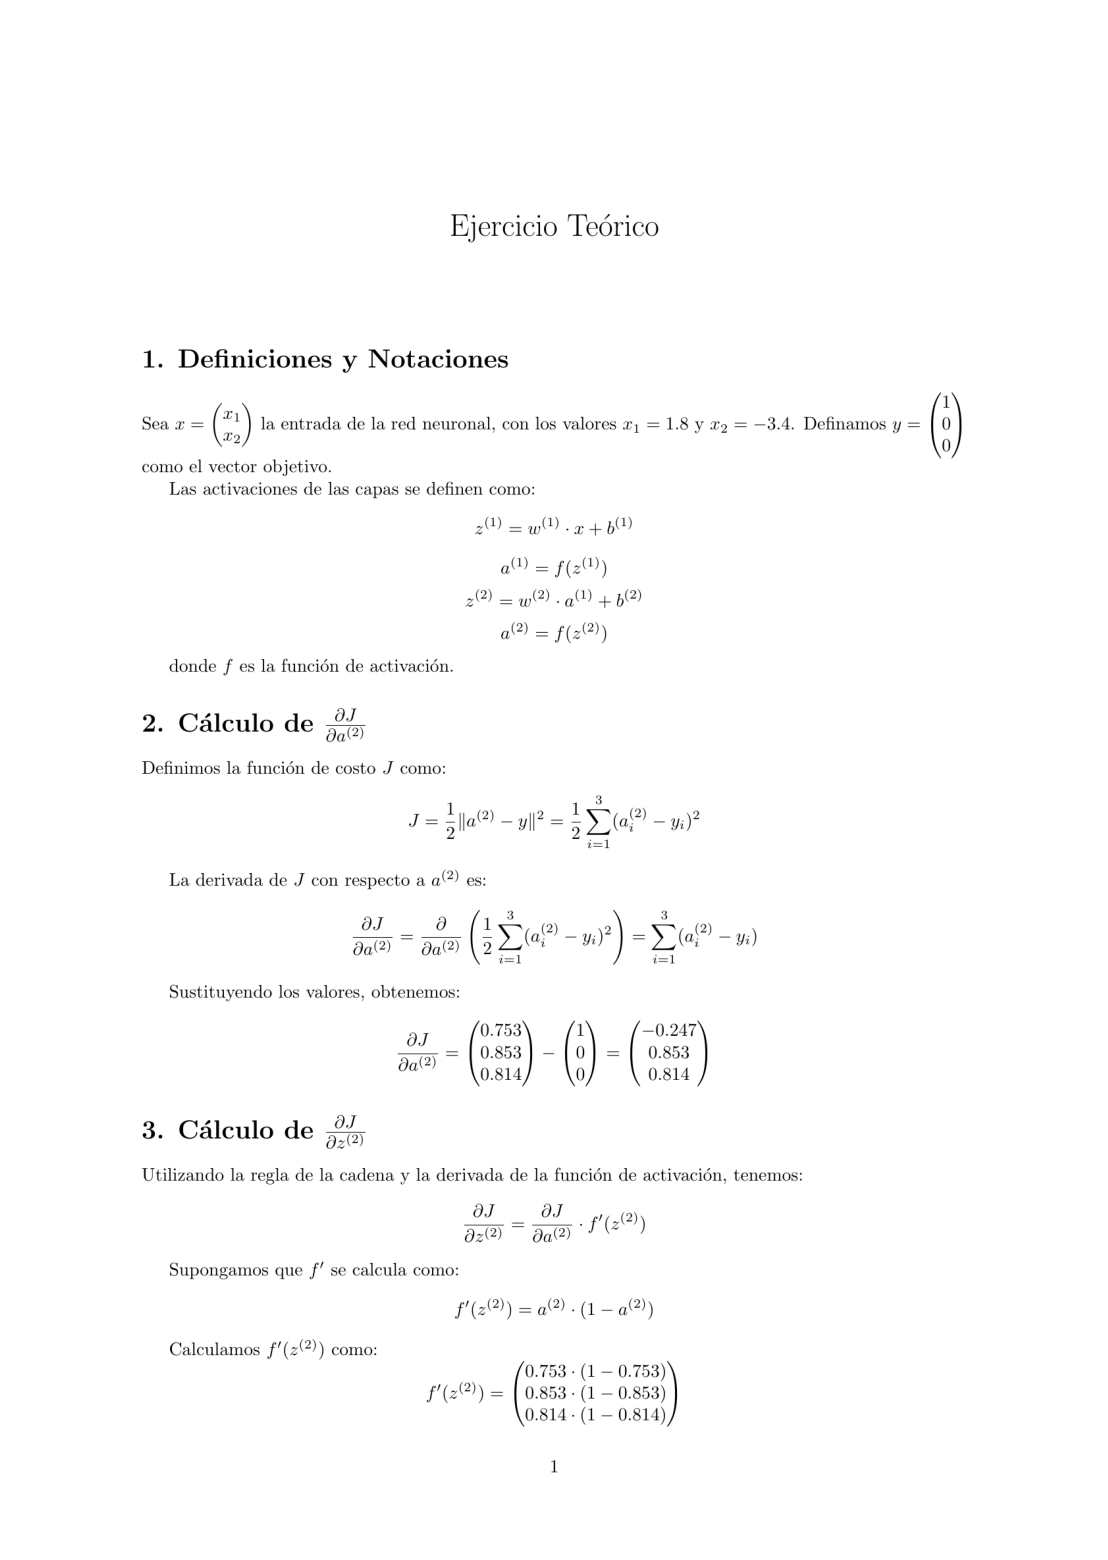

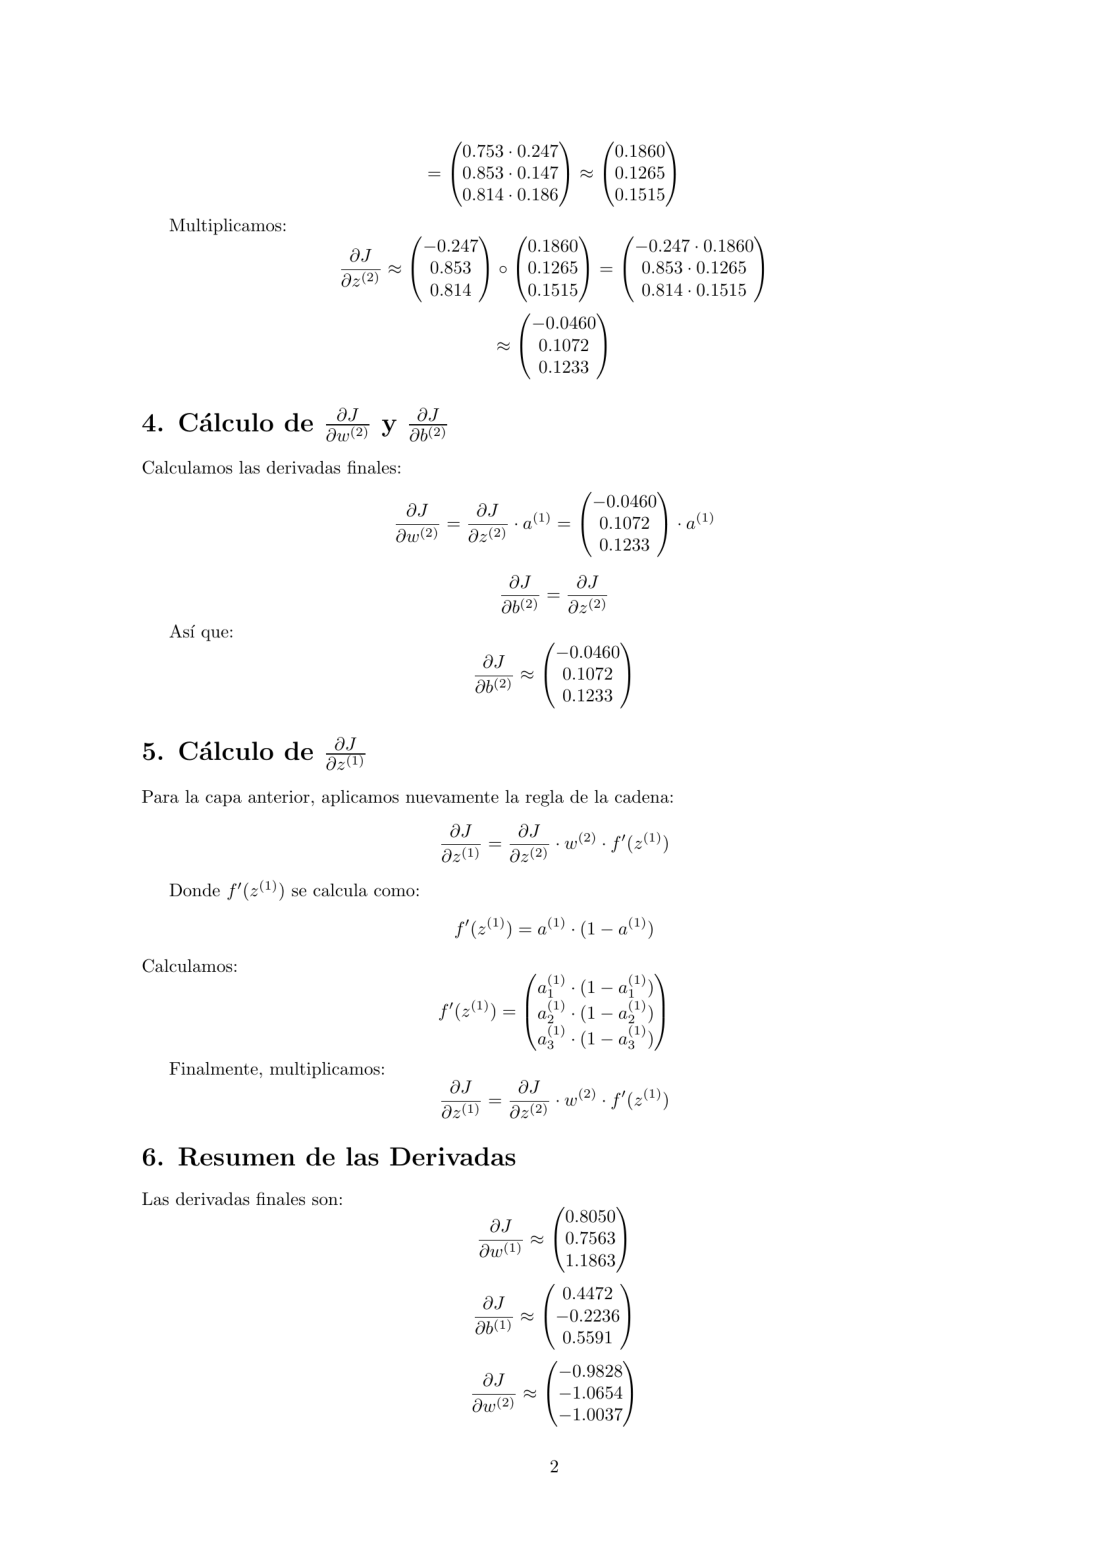

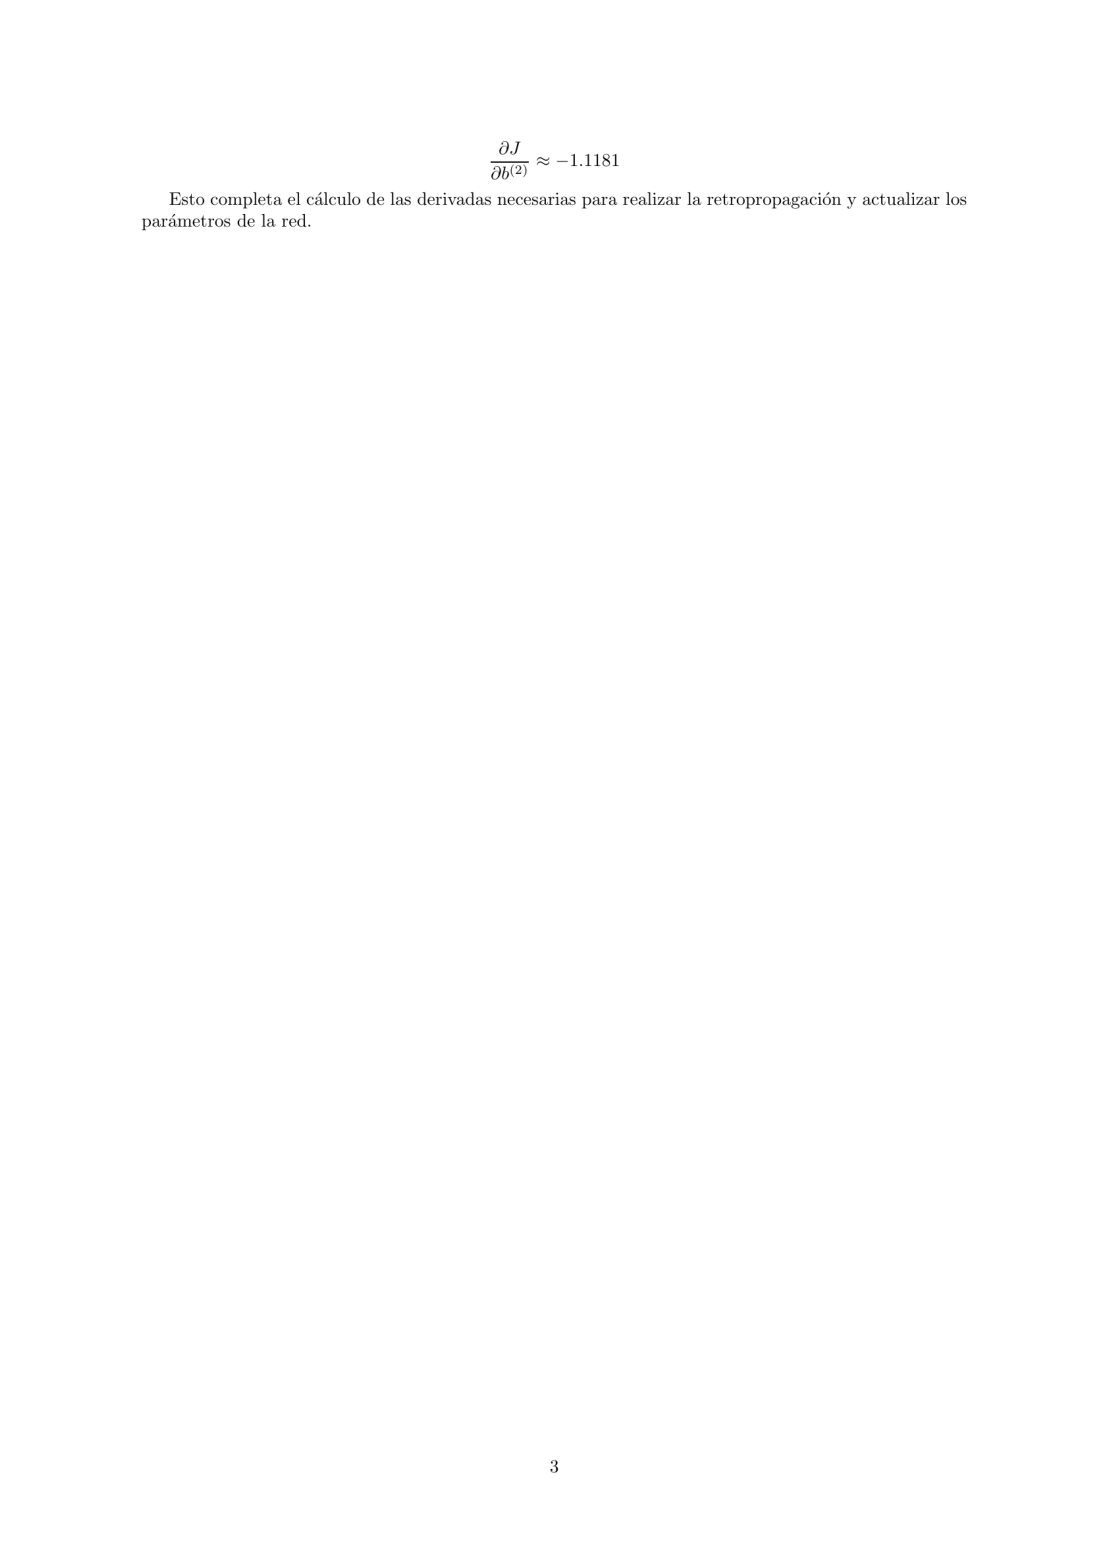

In [49]:
import os
from PIL import Image
import matplotlib.pyplot as plt

output_folder = 'EjercicioTeorico'

image_files = sorted([f for f in os.listdir(output_folder) if f.endswith('.png')])

for i in range(len(image_files)):
    image_path = os.path.join(output_folder, image_files[i])
    img = Image.open(image_path)
    
    plt.figure(figsize=(24, 20))
    plt.imshow(img)
    plt.axis('off') 
    plt.show()
